In [1]:
import pandas as pd
data = pd.read_csv("/home/regatte/Desktop/Machine-Learning/dataSets/ClickBait/clickbait_data.csv")
data

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [2]:
from sklearn.model_selection import train_test_split

text = data["headline"].values
clickbait_value = data["clickbait"].values

text_train, text_test, y_train, y_test = train_test_split(text, clickbait_value, test_size = 0.25)
print(text_train.shape, text_test.shape, y_train.shape, y_test.shape)

(24000,) (8000,) (24000,) (8000,)


In [3]:
import keras
from keras.preprocessing.text import Tokenizer
max_words = 10000                             #number of words to use, discarding the rest
max_len = 1000                                #no seq would be longer than 1000
embedding_size = 32

tkn = Tokenizer(num_words = max_words)
tkn.fit_on_texts(text)

X_train = tkn.texts_to_sequences(text_train)
x_test = tkn.texts_to_sequences(text_test)

from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
model = Sequential()
model.add(Embedding(max_words, embedding_size, input_length = max_len))         #layer 1: word embedding
model.add(LSTM(50, return_sequences=True))                                      #layer 2: LSTM layer, using 50 neurons
model.add(GlobalMaxPooling1D())                                                 #layer 3: pooling ID
model.add(Dropout(0.2))                                                         #layer 4: to avoid over-fitting
model.add(Dense(1, activation = 'sigmoid'))                                     #layer 5, to activate the whole model, using sigmoid as value is either 0 or 1, so either clickbait or non-clickbait
model.summary()                                                                 #summarizing all the layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 50)          16600     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 336,651
Trainable params: 336,651
Non-trainable params: 0
_________________________________________________________________


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = [
             EarlyStopping(
                 monitor = 'val_accuracy',
                 min_delta = 1e-4,
                 patience = 2, 
                 verbose = 1
             ),
             ModelCheckpoint(
                 filepath = '/home/regatte/Desktop/Machine-Learning/Models/ClickBait/model data/clickbait_weights.h5',
                 monitor='val_accuracy', 
                 mode='max', 
                 save_best_only=True,
                 save_weights_only=True,
                 verbose=1
             )
]

In [5]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_split=0.1, epochs=100, callbacks=[callbacks])

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.8092
Epoch 00001: val_accuracy improved from -inf to 0.94500, saving model to /home/regatte/Desktop/Machine-Learning/Models/ClickBait/model data/clickbait_weights.h5
43/43 [==============================] - 84s 2s/step - loss: 0.6586 - accuracy: 0.8092 - val_loss: 0.5572 - val_accuracy: 0.9450
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.9483
Epoch 00002: val_accuracy improved from 0.94500 to 0.96833, saving model to /home/regatte/Desktop/Machine-Learning/Models/ClickBait/model data/clickbait_weights.h5
43/43 [==============================] - 83s 2s/step - loss: 0.3946 - accuracy: 0.9483 - val_loss: 0.2254 - val_accuracy: 0.9683
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9729
Epoch 00003: val_accuracy improved from 0.96833 to 0.97500, saving model to /home/regatte/Desktop/Machine-Learning/Models/ClickBait/

In [6]:
model.save('/home/regatte/Desktop/Machine-Learning/Models/ClickBait/model data/clickbait_model.h5')
import pickle
with open("clickbait_tokenizer.pickle", 'wb') as handle:
    pickle.dump(tkn, handle, protocol=pickle.HIGHEST_PROTOCOL)

<Figure size 432x288 with 0 Axes>

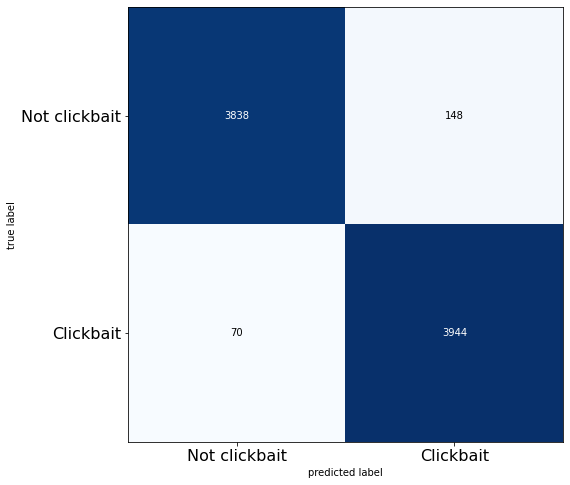

Recall of the model is 0.98
Precision of the model is 0.96


In [7]:
import matplotlib.pyplot as plt    
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

In [8]:
test = ['the new apple iPhone is very powerful when compared to laptops']
token_text = pad_sequences(tkn.texts_to_sequences(test), maxlen=max_len)
preds = [round(i[0]) for i in model.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

the new apple iPhone is very powerful when compared to laptops - Clickbait


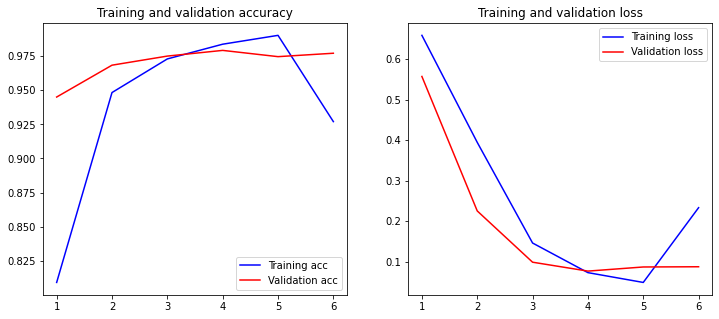

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
model.evaluate(x_test, y_test)

250/250 [==============================] - 28s 112ms/step - loss: 0.0958 - accuracy: 0.9728


[0.09584501385688782, 0.9727500081062317]

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
pred = model.predict(x_test)
bp=[]
for i in pred:
    if i>= 0.5:
        bp.append(1)
    else:
        bp.append(0)

print('Accuracy on testing set:',accuracy_score(bp, y_test))
print('Precision on testing set:',precision_score(bp, y_test))
print('Recal on testing set:',recall_score(bp, y_test))

Accuracy on testing set: 0.97275
Precision on testing set: 0.9825610363726955
Recal on testing set: 0.9638318670576735
